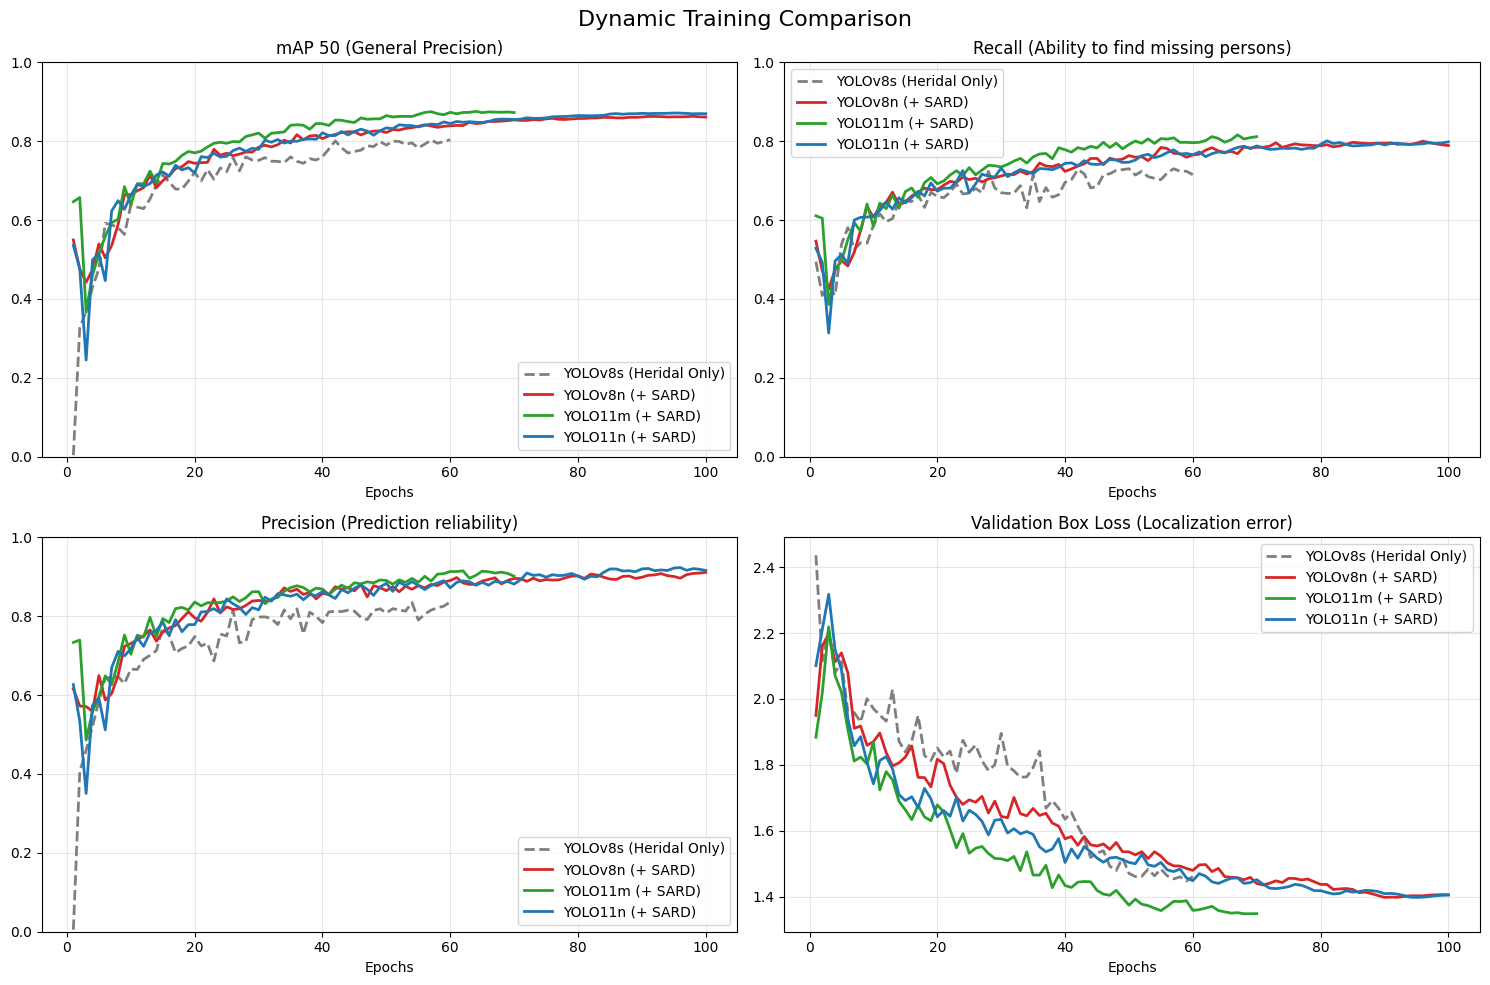

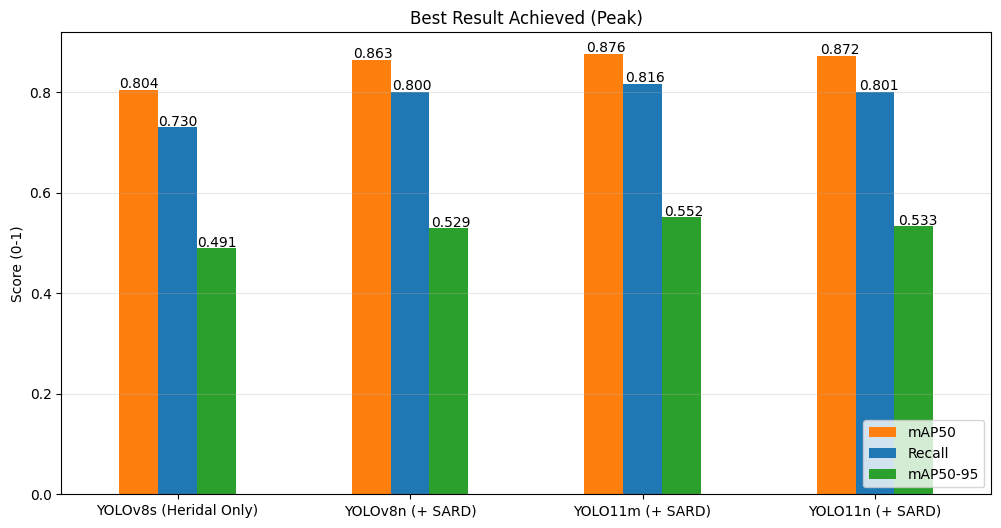

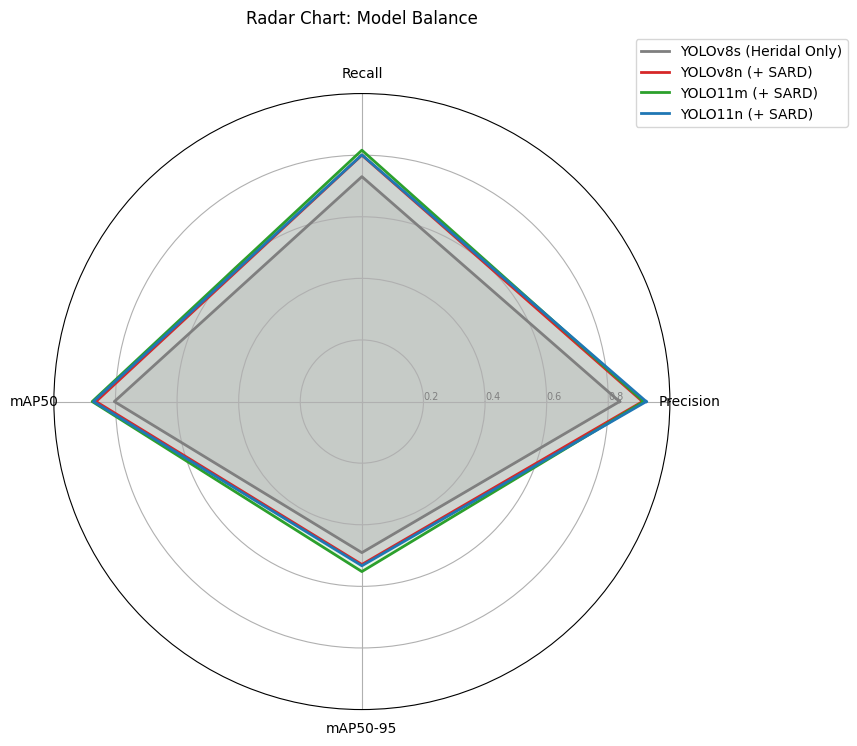


--- COMPARISON TABLE (Maximum Values) ---
                        Best mAP50  Best Recall  Best Precision
Model                                                          
YOLOv8s (Heridal Only)     0.80375      0.73028         0.83659
YOLOv8n (+ SARD)           0.86328      0.80020         0.91121
YOLO11m (+ SARD)           0.87564      0.81614         0.91510
YOLO11n (+ SARD)           0.87156      0.80102         0.92337


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- PATH CONFIGURATION ---
# Insert the paths to the results.csv files of your 4 experiments here.
runs_config = {
    "YOLOv8s (Heridal Only)": "/kaggle/input/yolo8s/results.csv",
    "YOLOv8n (+ SARD)":       "/kaggle/input/yolo8n/results.csv",
    "YOLO11m (+ SARD)":       "/kaggle/input/yolo11m/results (3).csv",
    "YOLO11n (+ SARD)":       "/kaggle/input/yolo11n/results.csv"
}

# Colors to distinguish models
colors = ['#7f7f7f', '#d62728', '#2ca02c', '#1f77b4']

def load_data(config):
    data = {}
    for label, path in config.items():
        if os.path.exists(path):
            df = pd.read_csv(path)
            # Clean column names
            df.columns = [c.strip() for c in df.columns]
            data[label] = df
        else:
            print(f"⚠️ WARNING: File not found: {path}")
    return data

def plot_comparison(data_dict):
    if not data_dict:
        print("No data to show.")
        return

    # 1. LEARNING CURVES (Line Plots)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Dynamic Training Comparison', fontsize=16)

    metrics_to_plot = [
        ('metrics/mAP50(B)', 'mAP 50 (General Precision)'),
        ('metrics/recall(B)', 'Recall (Ability to find missing persons)'),
        ('metrics/precision(B)', 'Precision (Prediction reliability)'),
        ('val/box_loss', 'Validation Box Loss (Localization error)')
    ]

    for ax, (metric, title) in zip(axs.flat, metrics_to_plot):
        for i, (label, df) in enumerate(data_dict.items()):
            if metric in df.columns:
                style = '--' if "Heridal Only" in label else '-'
                ax.plot(df['epoch'], df[metric], label=label, color=colors[i], linestyle=style, linewidth=2)

        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.grid(True, alpha=0.3)
        if 'Loss' not in title:
            ax.set_ylim(0, 1)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # 2. SUMMARY BAR CHART (Peaks)
    best_stats = []
    labels = []

    for label, df in data_dict.items():
        stats = [
            df['metrics/mAP50(B)'].max(),
            df['metrics/recall(B)'].max(),
            df['metrics/mAP50-95(B)'].max()
        ]
        best_stats.append(stats)
        labels.append(label)

    df_best = pd.DataFrame(best_stats, columns=['mAP50', 'Recall', 'mAP50-95'], index=labels)

    ax = df_best.plot(kind='bar', figsize=(12, 6), rot=0, color=['#ff7f0e', '#1f77b4', '#2ca02c'])
    plt.title('Best Result Achieved (Peak)')
    plt.ylabel('Score (0-1)')
    plt.grid(axis='y', alpha=0.3)
    plt.legend(loc='lower right')

    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()

    # 3. RADAR CHART
    categories = ['Precision', 'Recall', 'mAP50', 'mAP50-95']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for i, (label, df) in enumerate(data_dict.items()):
        values = [
            df['metrics/precision(B)'].max(),
            df['metrics/recall(B)'].max(),
            df['metrics/mAP50(B)'].max(),
            df['metrics/mAP50-95(B)'].max()
        ]
        values += values[:1]

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=label, color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=7)
    plt.ylim(0, 1)
    plt.title('Radar Chart: Model Balance', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()


# --- EXECUTION ---
training_data = load_data(runs_config)
plot_comparison(training_data)

print("\n--- COMPARISON TABLE (Maximum Values) ---")
summary = []
for lbl, df in training_data.items():
    if not df.empty:
        summary.append({
            "Model": lbl,
            "Best mAP50": df['metrics/mAP50(B)'].max(),
            "Best Recall": df['metrics/recall(B)'].max(),
            "Best Precision": df['metrics/precision(B)'].max()
        })
print(pd.DataFrame(summary).set_index("Model"))

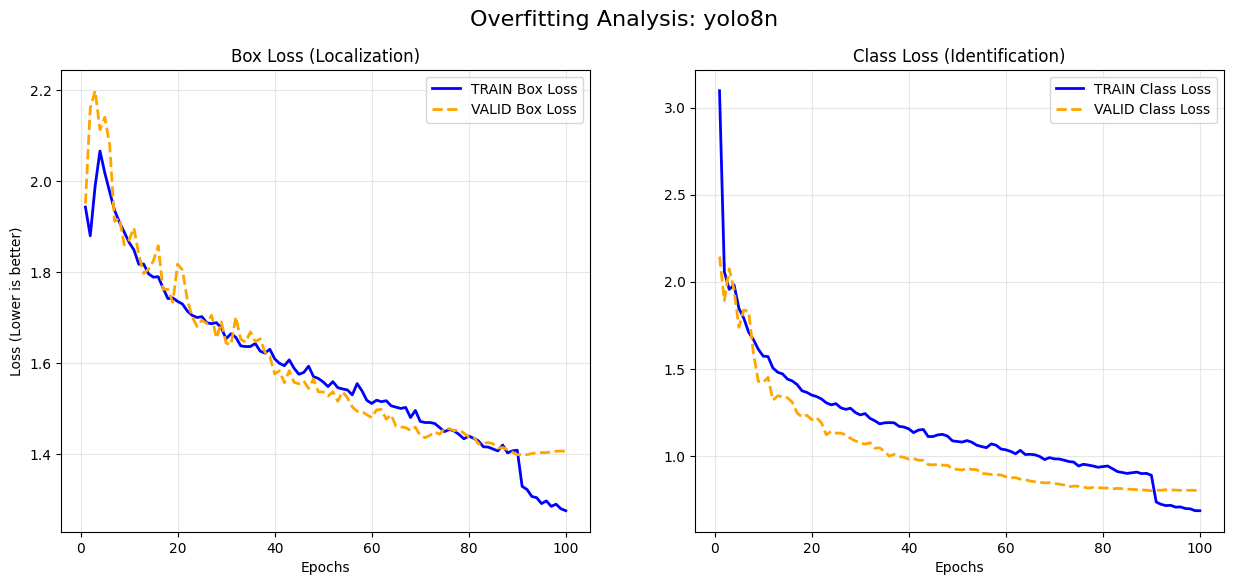


--- AUTOMATIC DIAGNOSIS ---
STABLE: The model has reached convergence (Plateau).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
# Insert the path to the results.csv file of the model you want to check
csv_path = "/kaggle/input/yolo8n/results.csv"

def check_overfitting(csv_file):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns] # Clean column names
    epochs = data['epoch']

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Overfitting Analysis: {os.path.basename(os.path.dirname(csv_file))}', fontsize=16)

    # 1. BOX LOSS (How well it draws the bounding box)
    axs[0].plot(epochs, data['train/box_loss'], label='TRAIN Box Loss', color='blue', linewidth=2)
    axs[0].plot(epochs, data['val/box_loss'], label='VALID Box Loss', color='orange', linewidth=2, linestyle='--')
    axs[0].set_title('Box Loss (Localization)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss (Lower is better)')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # 2. CLS LOSS (How well it identifies it as a person)
    axs[1].plot(epochs, data['train/cls_loss'], label='TRAIN Class Loss', color='blue', linewidth=2)
    axs[1].plot(epochs, data['val/cls_loss'], label='VALID Class Loss', color='orange', linewidth=2, linestyle='--')
    axs[1].set_title('Class Loss (Identification)')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)

    plt.show()

    # --- AUTOMATIC DIAGNOSIS ---
    # Take the last 10 epochs
    last_epochs = data.tail(10)
    train_trend = last_epochs['train/box_loss'].mean()
    val_trend = last_epochs['val/box_loss'].mean()

    # Calculate the slope (if it's going up or down)
    val_slope = list(last_epochs['val/box_loss'])[-1] - list(last_epochs['val/box_loss'])[0]

    print("\n--- AUTOMATIC DIAGNOSIS ---")
    if val_slope > 0.05:
        print("OVERFITTING ALERT: Validation Loss is rising in the last 10 epochs!")
        print("   -> The model is starting to memorize the training set.")
    elif abs(val_slope) < 0.01:
        print("STABLE: The model has reached convergence (Plateau).")
    else:
        print("IMPROVING: Loss is still decreasing. You could have trained longer.")

# EXECUTE
check_overfitting(csv_path)

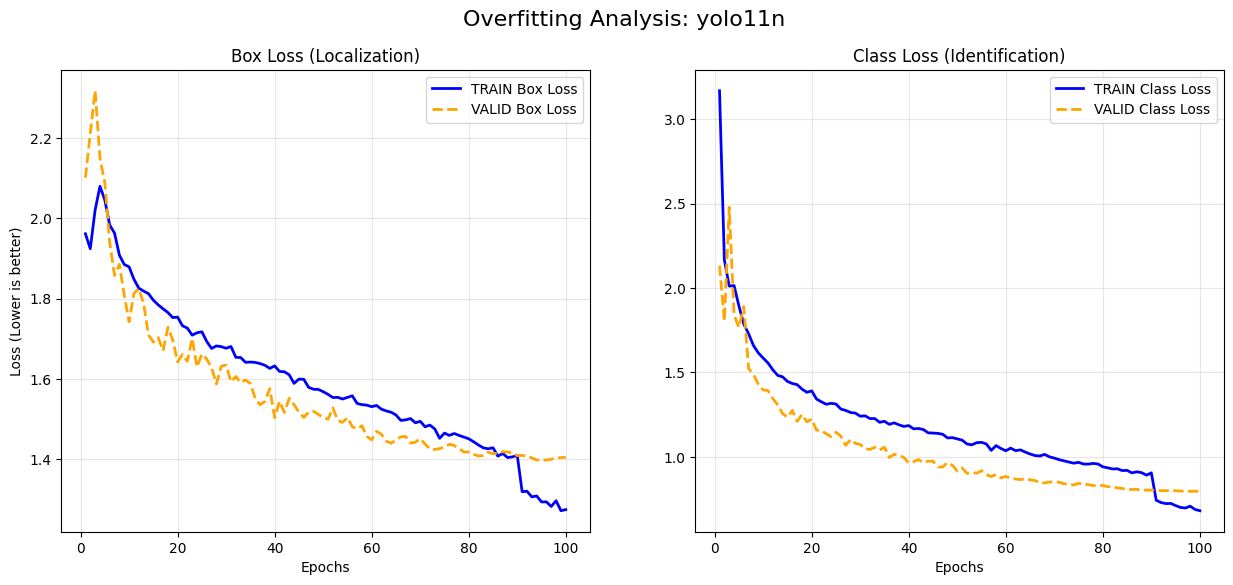


--- AUTOMATIC DIAGNOSIS ---
STABLE: The model has reached convergence (Plateau).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
# Insert the path to the results.csv file of the model you want to check
csv_path = "/kaggle/input/yolo11n/results.csv"

def check_overfitting(csv_file):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns] # Clean column names
    epochs = data['epoch']

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Overfitting Analysis: {os.path.basename(os.path.dirname(csv_file))}', fontsize=16)

    # 1. BOX LOSS (How well it draws the bounding box)
    axs[0].plot(epochs, data['train/box_loss'], label='TRAIN Box Loss', color='blue', linewidth=2)
    axs[0].plot(epochs, data['val/box_loss'], label='VALID Box Loss', color='orange', linewidth=2, linestyle='--')
    axs[0].set_title('Box Loss (Localization)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss (Lower is better)')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # 2. CLS LOSS (How well it identifies it as a person)
    axs[1].plot(epochs, data['train/cls_loss'], label='TRAIN Class Loss', color='blue', linewidth=2)
    axs[1].plot(epochs, data['val/cls_loss'], label='VALID Class Loss', color='orange', linewidth=2, linestyle='--')
    axs[1].set_title('Class Loss (Identification)')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)

    plt.show()

    # --- AUTOMATIC DIAGNOSIS ---
    # Take the last 10 epochs
    last_epochs = data.tail(10)
    train_trend = last_epochs['train/box_loss'].mean()
    val_trend = last_epochs['val/box_loss'].mean()

    # Calculate the slope (if it's going up or down)
    val_slope = list(last_epochs['val/box_loss'])[-1] - list(last_epochs['val/box_loss'])[0]

    print("\n--- AUTOMATIC DIAGNOSIS ---")
    if val_slope > 0.05:
        print("OVERFITTING ALERT: Validation Loss is rising in the last 10 epochs!")
        print("   -> The model is starting to memorize the training set.")
    elif abs(val_slope) < 0.01:
        print("STABLE: The model has reached convergence (Plateau).")
    else:
        print("IMPROVING: Loss is still decreasing. You could have trained longer.")

# EXECUTE
check_overfitting(csv_path)

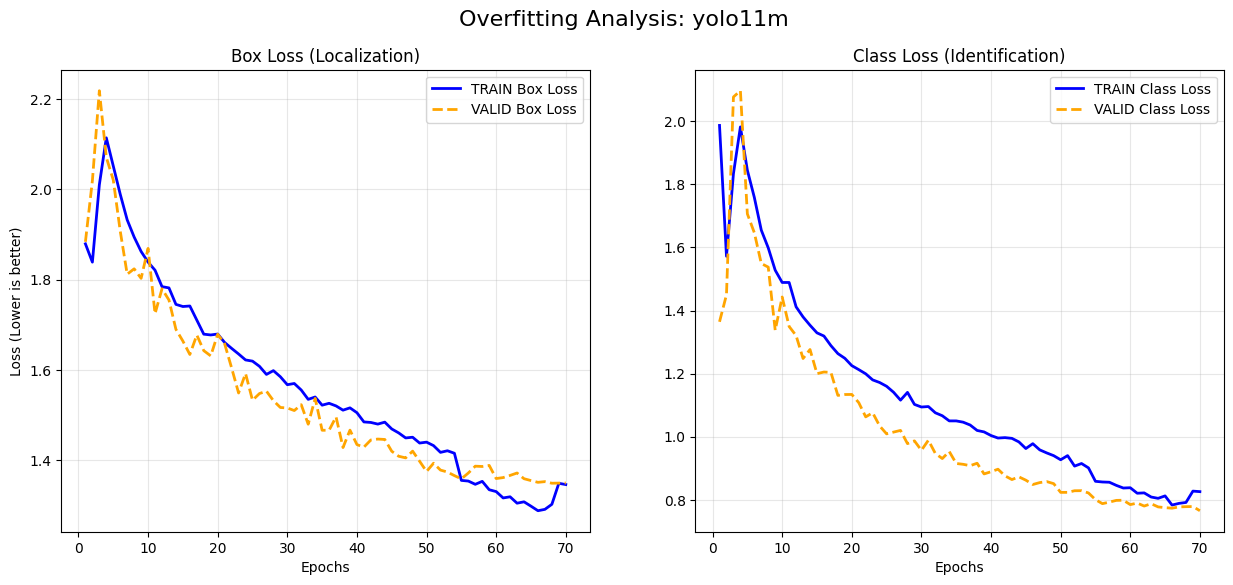


--- AUTOMATIC DIAGNOSIS ---
IMPROVING: Loss is still decreasing. You could have trained longer.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
# Insert the path to the results.csv file of the model you want to check
csv_path = "/kaggle/input/yolo11m/results (3).csv"

def check_overfitting(csv_file):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns] # Clean column names
    epochs = data['epoch']

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Overfitting Analysis: {os.path.basename(os.path.dirname(csv_file))}', fontsize=16)

    # 1. BOX LOSS (How well it draws the bounding box)
    axs[0].plot(epochs, data['train/box_loss'], label='TRAIN Box Loss', color='blue', linewidth=2)
    axs[0].plot(epochs, data['val/box_loss'], label='VALID Box Loss', color='orange', linewidth=2, linestyle='--')
    axs[0].set_title('Box Loss (Localization)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss (Lower is better)')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # 2. CLS LOSS (How well it identifies it as a person)
    axs[1].plot(epochs, data['train/cls_loss'], label='TRAIN Class Loss', color='blue', linewidth=2)
    axs[1].plot(epochs, data['val/cls_loss'], label='VALID Class Loss', color='orange', linewidth=2, linestyle='--')
    axs[1].set_title('Class Loss (Identification)')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)

    plt.show()

    # --- AUTOMATIC DIAGNOSIS ---
    # Take the last 10 epochs
    last_epochs = data.tail(10)
    train_trend = last_epochs['train/box_loss'].mean()
    val_trend = last_epochs['val/box_loss'].mean()

    # Calculate the slope (if it's going up or down)
    val_slope = list(last_epochs['val/box_loss'])[-1] - list(last_epochs['val/box_loss'])[0]

    print("\n--- AUTOMATIC DIAGNOSIS ---")
    if val_slope > 0.05:
        print("OVERFITTING ALERT: Validation Loss is rising in the last 10 epochs!")
        print("   -> The model is starting to memorize the training set.")
    elif abs(val_slope) < 0.01:
        print("STABLE: The model has reached convergence (Plateau).")
    else:
        print("IMPROVING: Loss is still decreasing. You could have trained longer.")

# EXECUTE
check_overfitting(csv_path)

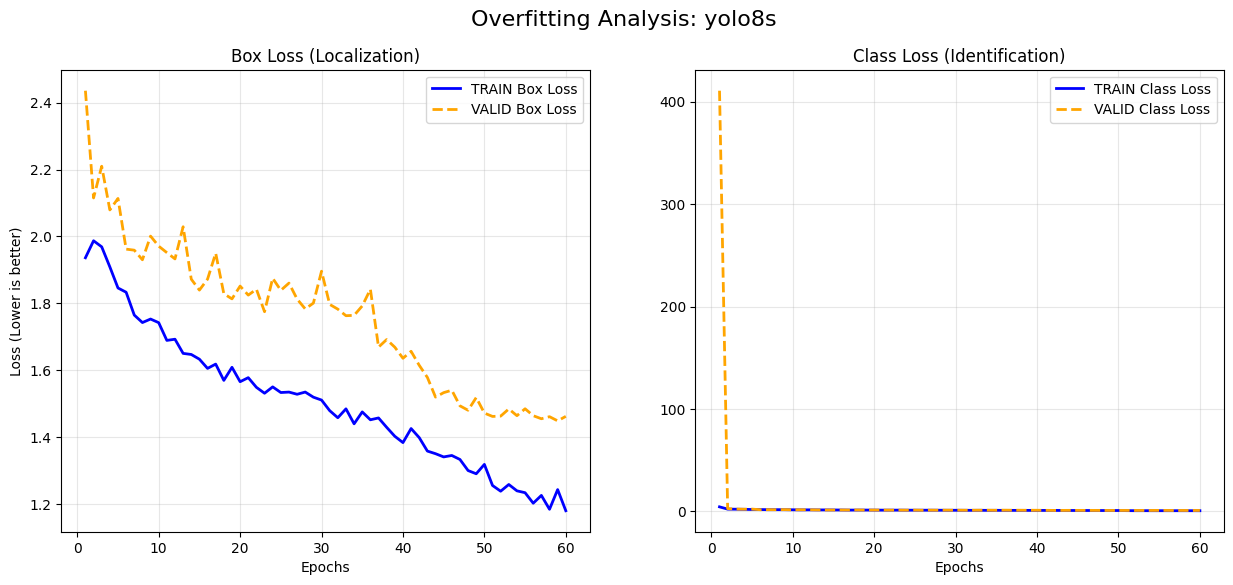


--- AUTOMATIC DIAGNOSIS ---
STABLE: The model has reached convergence (Plateau).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
# Insert the path to the results.csv file of the model you want to check
csv_path = "/kaggle/input/yolo8s/results.csv"

def check_overfitting(csv_file):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns] # Clean column names
    epochs = data['epoch']

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Overfitting Analysis: {os.path.basename(os.path.dirname(csv_file))}', fontsize=16)

    # 1. BOX LOSS (How well it draws the bounding box)
    axs[0].plot(epochs, data['train/box_loss'], label='TRAIN Box Loss', color='blue', linewidth=2)
    axs[0].plot(epochs, data['val/box_loss'], label='VALID Box Loss', color='orange', linewidth=2, linestyle='--')
    axs[0].set_title('Box Loss (Localization)')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss (Lower is better)')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # 2. CLS LOSS (How well it identifies it as a person)
    axs[1].plot(epochs, data['train/cls_loss'], label='TRAIN Class Loss', color='blue', linewidth=2)
    axs[1].plot(epochs, data['val/cls_loss'], label='VALID Class Loss', color='orange', linewidth=2, linestyle='--')
    axs[1].set_title('Class Loss (Identification)')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)

    plt.show()

    # --- AUTOMATIC DIAGNOSIS ---
    # Take the last 10 epochs
    last_epochs = data.tail(10)
    train_trend = last_epochs['train/box_loss'].mean()
    val_trend = last_epochs['val/box_loss'].mean()

    # Calculate the slope (if it's going up or down)
    val_slope = list(last_epochs['val/box_loss'])[-1] - list(last_epochs['val/box_loss'])[0]

    print("\n--- AUTOMATIC DIAGNOSIS ---")
    if val_slope > 0.05:
        print("OVERFITTING ALERT: Validation Loss is rising in the last 10 epochs!")
        print("   -> The model is starting to memorize the training set.")
    elif abs(val_slope) < 0.01:
        print("STABLE: The model has reached convergence (Plateau).")
    else:
        print("IMPROVING: Loss is still decreasing. You could have trained longer.")

# EXECUTE
check_overfitting(csv_path)

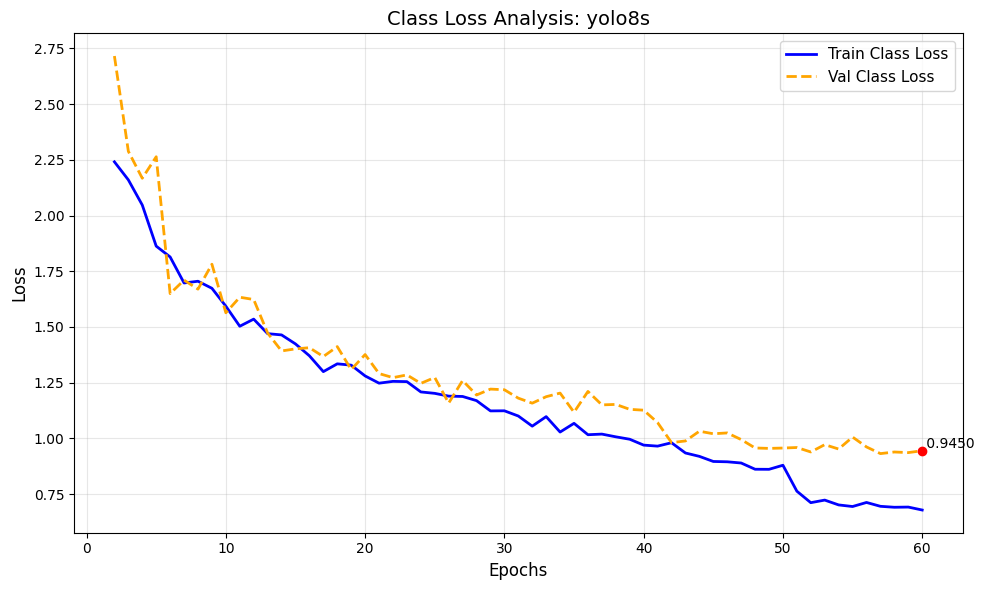


--- DIAGNOSIS ---
Slope (last 10 epochs): -0.01442
IMPROVING: Loss is still decreasing.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
csv_path = "/kaggle/input/yolo8s/results.csv"

def plot_class_loss_only(csv_file):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns] # Clean column names

    data = data[data['epoch'] > 1]

    # Generic alternative (simply removes the first row of the file):
    # data = data.iloc[1:]

    epochs = data['epoch']

    # --- SINGLE PLOT: CLASS LOSS ---
    plt.figure(figsize=(10, 6))

    # Train Loss
    plt.plot(epochs, data['train/cls_loss'], label='Train Class Loss', color='blue', linewidth=2)

    # Validation Loss
    plt.plot(epochs, data['val/cls_loss'], label='Val Class Loss', color='orange', linewidth=2, linestyle='--')

    # Highlight the final point
    last_epoch = epochs.iloc[-1]
    last_val_loss = data['val/cls_loss'].iloc[-1]
    plt.scatter(last_epoch, last_val_loss, color='red', zorder=5)
    plt.text(last_epoch, last_val_loss, f' {last_val_loss:.4f}', verticalalignment='bottom')

    # Labels and Titles
    plt.title(f'Class Loss Analysis: {os.path.basename(os.path.dirname(csv_file))}', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- AUTOMATIC DIAGNOSIS ---
    # Safety check in case few epochs remain after filtering
    if len(data) >= 10:
        last_epochs = data.tail(10)
        val_slope = list(last_epochs['val/cls_loss'])[-1] - list(last_epochs['val/cls_loss'])[0]

        print("\n--- DIAGNOSIS ---")
        print(f"Slope (last 10 epochs): {val_slope:.5f}")

        if val_slope > 0.005:
            print("OVERFITTING ALERT: Validation Loss is rising.")
        elif val_slope < -0.005:
            print("IMPROVING: Loss is still decreasing.")
        else:
            print("STABLE: Convergence reached.")
    else:
        print("Not enough data for diagnosis.")

# EXECUTE
plot_class_loss_only(csv_path)

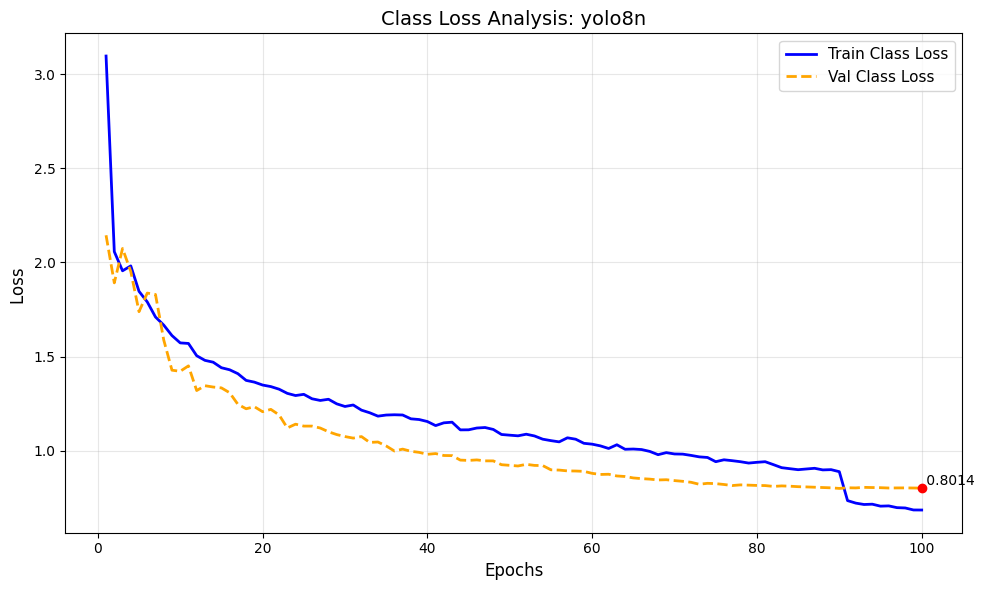


--- DIAGNOSIS ---
Slope (last 10 epochs): -0.00156
✅ STABLE: Convergence reached.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
csv_path = "/kaggle/input/yolo8n/results.csv"

def plot_class_loss_only(csv_file):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns] # Clean column names
    epochs = data['epoch']

    # --- SINGLE PLOT: CLASS LOSS ---
    plt.figure(figsize=(10, 6))

    # Train Loss
    plt.plot(epochs, data['train/cls_loss'], label='Train Class Loss', color='blue', linewidth=2)

    # Validation Loss
    plt.plot(epochs, data['val/cls_loss'], label='Val Class Loss', color='orange', linewidth=2, linestyle='--')

    # Highlight the final point
    last_epoch = epochs.iloc[-1]
    last_val_loss = data['val/cls_loss'].iloc[-1]
    plt.scatter(last_epoch, last_val_loss, color='red', zorder=5)
    plt.text(last_epoch, last_val_loss, f' {last_val_loss:.4f}', verticalalignment='bottom')

    # Labels and Titles (English)
    plt.title(f'Class Loss Analysis: {os.path.basename(os.path.dirname(csv_file))}', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss ', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- AUTOMATIC DIAGNOSIS ---
    last_epochs = data.tail(10)
    val_slope = list(last_epochs['val/cls_loss'])[-1] - list(last_epochs['val/cls_loss'])[0]

    print("\n--- DIAGNOSIS ---")
    print(f"Slope (last 10 epochs): {val_slope:.5f}")

    if val_slope > 0.005:
        print("OVERFITTING ALERT: Validation Loss is rising.")
    elif val_slope < -0.005:
        print("IMPROVING: Loss is still decreasing.")
    else:
        print("STABLE: Convergence reached.")

# EXECUTE
plot_class_loss_only(csv_path)

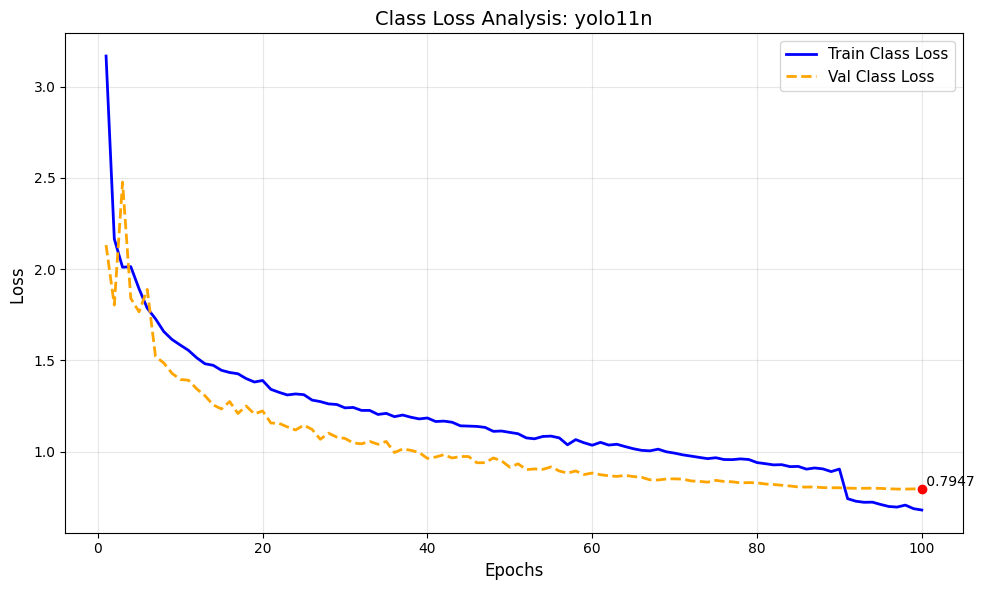


--- DIAGNOSIS ---
Slope (last 10 epochs): -0.00576
📉 IMPROVING: Loss is still decreasing.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
csv_path = "/kaggle/input/yolo11n/results.csv"

def plot_class_loss_only(csv_file):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns] # Clean column names
    epochs = data['epoch']

    # --- SINGLE PLOT: CLASS LOSS ---
    plt.figure(figsize=(10, 6))

    # Train Loss
    plt.plot(epochs, data['train/cls_loss'], label='Train Class Loss', color='blue', linewidth=2)

    # Validation Loss
    plt.plot(epochs, data['val/cls_loss'], label='Val Class Loss', color='orange', linewidth=2, linestyle='--')

    # Highlight the final point
    last_epoch = epochs.iloc[-1]
    last_val_loss = data['val/cls_loss'].iloc[-1]
    plt.scatter(last_epoch, last_val_loss, color='red', zorder=5)
    plt.text(last_epoch, last_val_loss, f' {last_val_loss:.4f}', verticalalignment='bottom')

    # Labels and Titles (English)
    plt.title(f'Class Loss Analysis: {os.path.basename(os.path.dirname(csv_file))}', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss ', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- AUTOMATIC DIAGNOSIS ---
    last_epochs = data.tail(10)
    val_slope = list(last_epochs['val/cls_loss'])[-1] - list(last_epochs['val/cls_loss'])[0]

    print("\n--- DIAGNOSIS ---")
    print(f"Slope (last 10 epochs): {val_slope:.5f}")

    if val_slope > 0.005:
        print("OVERFITTING ALERT: Validation Loss is rising.")
    elif val_slope < -0.005:
        print("IMPROVING: Loss is still decreasing.")
    else:
        print("STABLE: Convergence reached.")

# EXECUTE
plot_class_loss_only(csv_path)

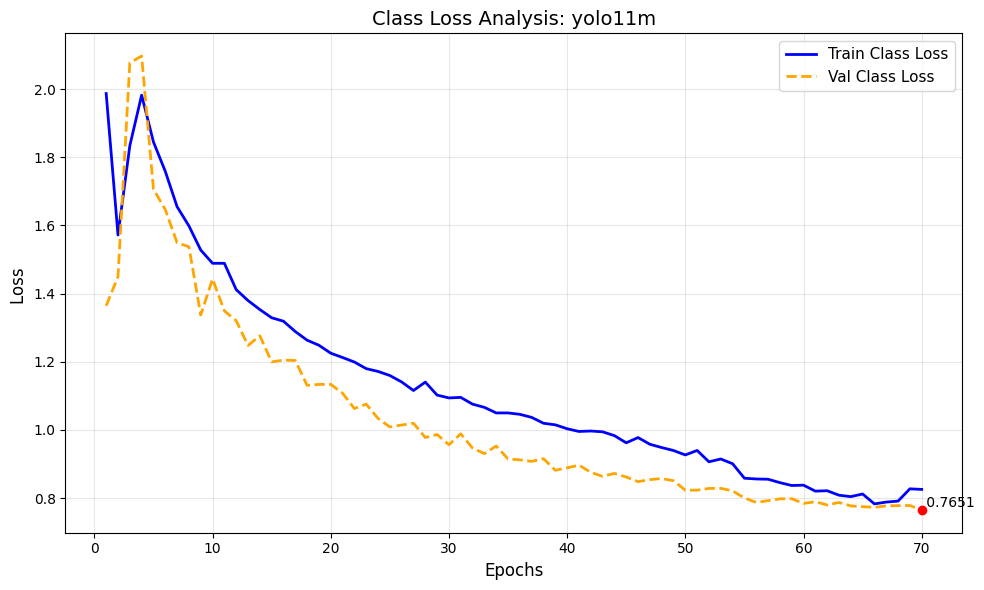


--- DIAGNOSIS ---
Slope (last 10 epochs): -0.02427
📉 IMPROVING: Loss is still decreasing.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
csv_path = "/kaggle/input/yolo11m/results (3).csv"

def plot_class_loss_only(csv_file):
    if not os.path.exists(csv_file):
        print(f"File not found: {csv_file}")
        return

    data = pd.read_csv(csv_file)
    data.columns = [c.strip() for c in data.columns] # Clean column names
    epochs = data['epoch']

    # --- SINGLE PLOT: CLASS LOSS ---
    plt.figure(figsize=(10, 6))

    # Train Loss
    plt.plot(epochs, data['train/cls_loss'], label='Train Class Loss', color='blue', linewidth=2)

    # Validation Loss
    plt.plot(epochs, data['val/cls_loss'], label='Val Class Loss', color='orange', linewidth=2, linestyle='--')

    # Highlight the final point
    last_epoch = epochs.iloc[-1]
    last_val_loss = data['val/cls_loss'].iloc[-1]
    plt.scatter(last_epoch, last_val_loss, color='red', zorder=5)
    plt.text(last_epoch, last_val_loss, f' {last_val_loss:.4f}', verticalalignment='bottom')

    # Labels and Titles (English)
    plt.title(f'Class Loss Analysis: {os.path.basename(os.path.dirname(csv_file))}', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss ', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- AUTOMATIC DIAGNOSIS ---
    last_epochs = data.tail(10)
    val_slope = list(last_epochs['val/cls_loss'])[-1] - list(last_epochs['val/cls_loss'])[0]

    print("\n--- DIAGNOSIS ---")
    print(f"Slope (last 10 epochs): {val_slope:.5f}")

    if val_slope > 0.005:
        print("OVERFITTING ALERT: Validation Loss is rising.")
    elif val_slope < -0.005:
        print("IMPROVING: Loss is still decreasing.")
    else:
        print("STABLE: Convergence reached.")

# EXECUTE
plot_class_loss_only(csv_path)

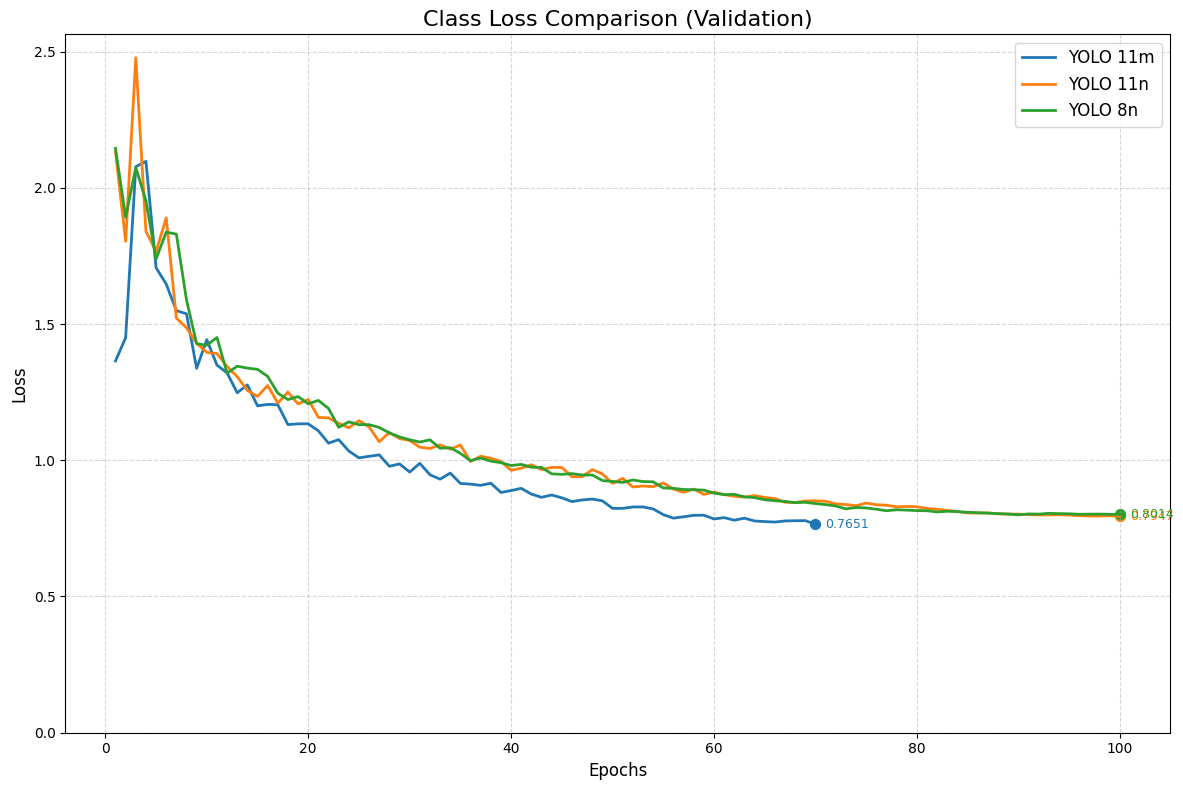

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
# Insert here the names and paths of your 3 models
models_config = {
    "YOLO 11m": "/kaggle/input/yolo11m/results (3).csv",
    "YOLO 11n":     "/kaggle/input/yolo11n/results.csv",
    "YOLO 8n":     "/kaggle/input/yolo8n/results.csv"
}

# Colors for the lines
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

def plot_multi_class_loss(config):
    plt.figure(figsize=(12, 8))

    # Loop through the dictionary to plot each model
    for i, (label, path) in enumerate(config.items()):
        if not os.path.exists(path):
            print(f"⚠️ File not found: {path}")
            continue

        # Load Data
        df = pd.read_csv(path)
        df.columns = [c.strip() for c in df.columns] # Clean column names

        # Check if metric exists
        if 'val/cls_loss' in df.columns:
            epochs = df['epoch']
            loss = df['val/cls_loss']

            # Plot Line
            plt.plot(epochs, loss, label=label, color=colors[i % len(colors)], linewidth=2)

            # Mark the final point (End of training)
            plt.scatter(epochs.iloc[-1], loss.iloc[-1], color=colors[i % len(colors)], s=50)
            # Add text annotation for the final value
            plt.text(epochs.iloc[-1] + 1, loss.iloc[-1], f'{loss.iloc[-1]:.4f}',
                     verticalalignment='center', fontsize=9, color=colors[i % len(colors)])
        else:
            print(f"⚠️ 'val/cls_loss' column not found in {label}")

    # --- FORMATTING (English) ---
    plt.title('Class Loss Comparison (Validation)', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Limit Y axis automatically but keep 0 at the bottom for clarity
    plt.ylim(bottom=0)

    plt.tight_layout()
    plt.show()

# EXECUTE
plot_multi_class_loss(models_config)